In [34]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense

from keras.models import Sequential, Model
#rom keras.applications.xception import Xception
#from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop

import tensorflow as tf

import os
import numpy as np
import pandas as np

import matplotlib.pyplot as plt
%matplotlib inline


In [35]:
TRAIN_DIR = "../input/chest-xray-pneumonia/chest_xray/train/"
VAL_DIR = "../input/chest-xray-pneumonia/chest_xray/val/"
TEST_DIR = "../input/chest-xray-pneumonia/chest_xray/test/"

IMG_W = 150
IMG_H = 150
CHANNELS = 3

INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NB_CLASSES = 2
EPOCHS = 25
BATCH_SIZE = 16


In [36]:
print("Train data : " , os.listdir(TRAIN_DIR))
print("Validation data : " , os.listdir(VAL_DIR))
print("Test data : " , os.listdir(TEST_DIR))

Train data :  ['NORMAL', 'PNEUMONIA']
Validation data :  ['NORMAL', 'PNEUMONIA']
Test data :  ['NORMAL', 'PNEUMONIA']


NORMAL


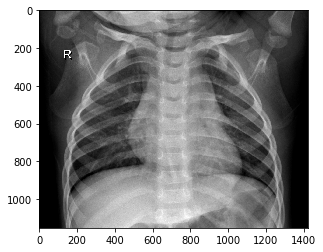

In [37]:
img_name = 'IM-0117-0001.jpeg'
img_normal = load_img(TRAIN_DIR + "NORMAL/" + img_name)

print('NORMAL')
plt.imshow(img_normal)
plt.show()

PNEUMONIA


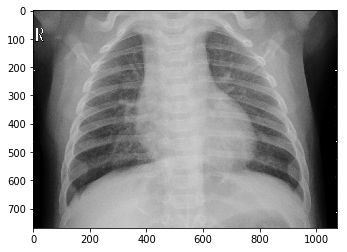

In [38]:
img_name = 'person1000_virus_1681.jpeg'
img_pneumonia = load_img(TRAIN_DIR + "PNEUMONIA/" + img_name)

print('PNEUMONIA')
plt.imshow(img_pneumonia)
plt.show()

In [39]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [40]:
# CNN model (VGG-like)
model = Sequential()

## Stage 1
model.add(Conv2D(32,(3,3),activation='relu',input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

## Stage 2
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

## Stage 3
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

## Stage 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))


## Output
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [41]:
base_model = VGG16(include_top=False,
                    input_shape = INPUT_SHAPE,
                    weights = 'imagenet')

for layer in base_model.layers[:-12]:
    layer.trainable = False
    
for layer in base_model.layers:
    print(layer,layer.trainable)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

<keras.engine.input_layer.InputLayer object at 0x7fd9a6950e80> False
<keras.layers.convolutional.Conv2D object at 0x7fd9a6950cf8> False
<keras.layers.convolutional.Conv2D object at 0x7fd9a67f8198> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd9a67756a0> False
<keras.layers.convolutional.Conv2D object at 0x7fd9a674ec50> False
<keras.layers.convolutional.Conv2D object at 0x7fd9a6726860> False
<keras.layers.pooling.MaxPooling2D object at 0x7fd9a6736320> False
<keras.layers.convolutional.Conv2D object at 0x7fd9a6736160> True
<keras.layers.convolutional.Conv2D object at 0x7fd9a6736cc0> True
<keras.layers.convolutional.Conv2D object at 0x7fd9a438f6d8> True
<keras.layers.pooling.MaxPooling2D object at 0x7fd9a438fdd8> True
<keras.layers.convolutional.Conv2D object at 0x7fd9a438fda0> True
<keras.layers.convolutional.Conv2D object at 0x7fd9a4396710> True
<keras.layers.convolutional.Conv2D object at 0x7fd9a439e400> True
<keras.layers.pooling.MaxPooling2D object at 0x7fd9a439ecf8> True
<

In [42]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
#model.compile(Adam(lr=0.0001),loss="binary_crossentropy", metrics=["accuracy"])

In [44]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

In [45]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [46]:
augs = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_augs = ImageDataGenerator(rescale=1./255)

train_gen = augs.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_W, IMG_H),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_gen = val_augs.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_W, IMG_H),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_gen = val_augs.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_W, IMG_H),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [47]:
nb_train_samples = 5217
nb_val_samples = 17

In [50]:
model.fit_generator(
    train_gen,
    steps_per_epoch=nb_train_samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=nb_val_samples // BATCH_SIZE)


Epoch 1/25
326/326 [==============================] - 106s 326ms/step - loss: 790.9967 - accuracy: 0.7203 - val_loss: 0.7288 - val_accuracy: 0.5000
Epoch 2/25
326/326 [==============================] - 89s 273ms/step - loss: 0.7234 - accuracy: 0.7372 - val_loss: 0.6428 - val_accuracy: 0.5000
Epoch 3/25
326/326 [==============================] - 88s 271ms/step - loss: 2.7579 - accuracy: 0.7500 - val_loss: 31.3934 - val_accuracy: 0.6250
Epoch 4/25
326/326 [==============================] - 88s 271ms/step - loss: 1.0449 - accuracy: 0.7872 - val_loss: 0.5688 - val_accuracy: 0.8125
Epoch 5/25
326/326 [==============================] - 90s 276ms/step - loss: 0.5099 - accuracy: 0.8384 - val_loss: 1.5240 - val_accuracy: 0.6250
Epoch 6/25
326/326 [==============================] - 90s 276ms/step - loss: 0.3870 - accuracy: 0.8692 - val_loss: 15.7938 - val_accuracy: 0.5000
Epoch 7/25
326/326 [==============================] - 90s 275ms/step - loss: 0.7500 - accuracy: 0.8811 - val_loss: 0.6575 - v